<a href="https://colab.research.google.com/github/DannMacias/ztm_pytorch/blob/main/01_pytorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> PyTorch Workflow Fundamentals </b>

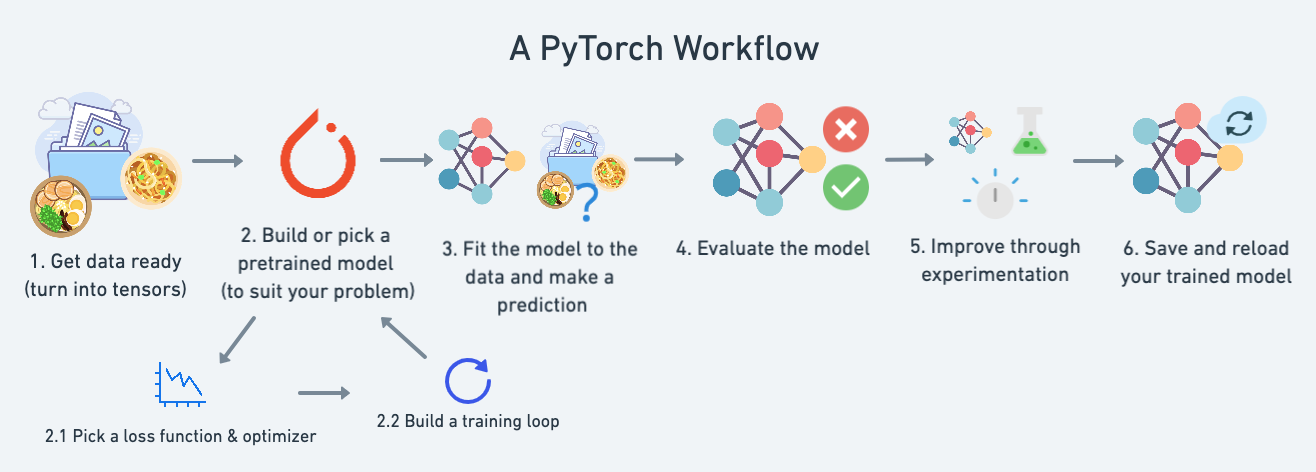

In [ ]:
import torch

# nn contains all of PyTorch's building blocks for neural networks
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

# 1. Data (preparing and loading)

We'll use a *linear regression* to create the data with known **parameters** (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using **gradient descent**.

In [ ]:
# Create "known" parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now we're going to move towards building a model than can learn the relationship between `X` (**features**) and `y` (**labels**).

## Split data into training and test sets



In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split] 
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Let's create a function to visualize it

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize = (10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop = {"size":14});

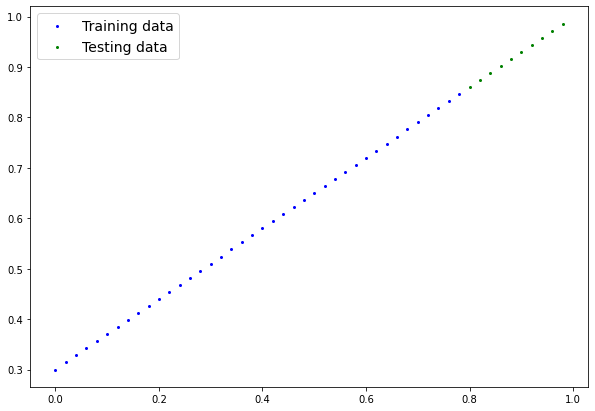

In [ ]:
plot_predictions()

# 2. Build the model

Almost everything in a PyTorch neural network comes from `torch.nn`:
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`)
* `forward()` tells the larger blocks how to make calculations on inputs (tensor full of data) within `nn.Module`
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

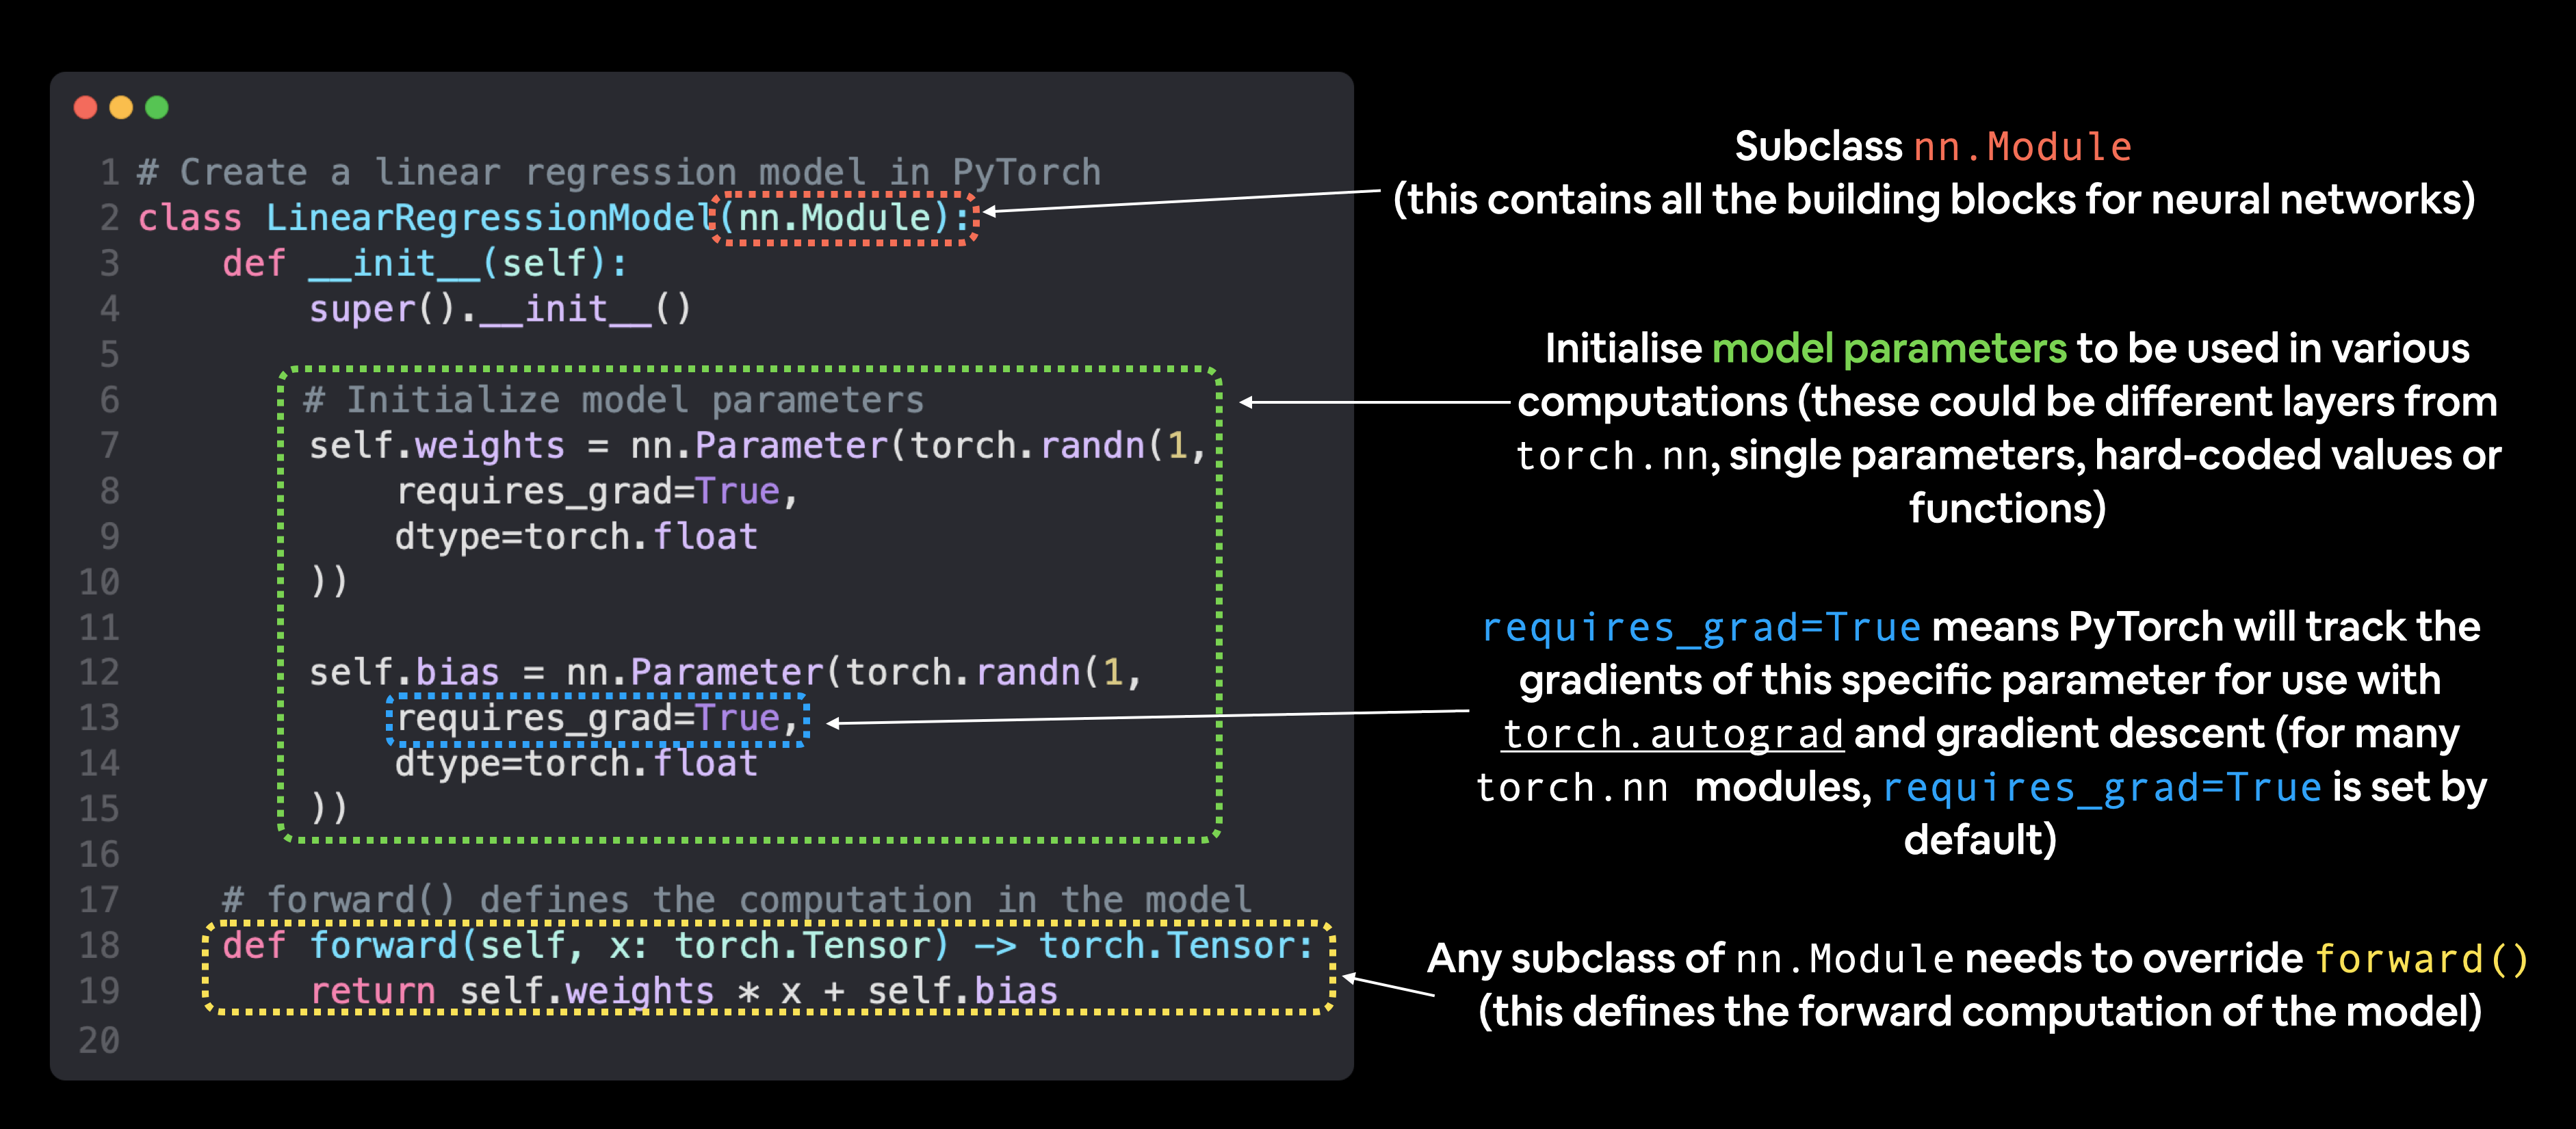

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

## Checking the contents of a PyTorch model

Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using `.parameters()`

In [ ]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter)
model_0 = LinearRegressionModel()

# Check the nn.Parameters within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()`.

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best.

Because our model starts with random values, right now it'll have poor predictive power.

## Making predictions using `torch.inference_mode()`

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

Let's make some predictions.

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

You probably noticed we used `torch.inference_mode()` as a **context manager** (that's what the `with torch.inference_mode():` is) to make predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, whic is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster.

We've made some predictions, let's see what they look like:

In [ ]:
# Check the predictions
print(f"Number of testing samples : {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples : 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


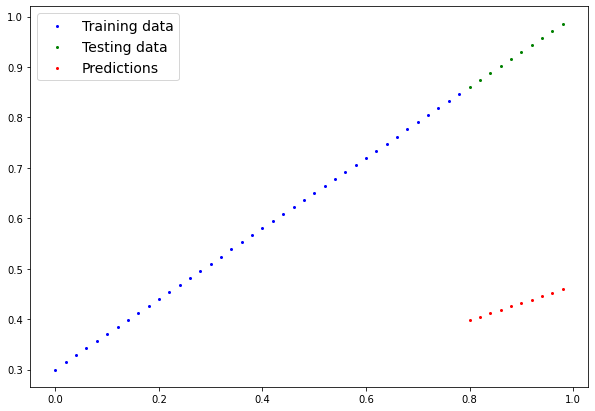

In [ ]:
plot_predictions(predictions=y_preds)

Those predictions look pretty bad. 

This is make sense though when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

# 3. Train the model

## Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more thing to our recipe.

**Loss function** - Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better.
* ***Where does it live in PyTorch?***: PyTorch has plenty of built-in loss functions in `torch.nn`.
* ***Common values***:
  * Mean absolute error (MAE) for *regression* problems (`torch.nn.L1Loss()`).
  * Binary cross entropy for binary *classification* problems (`torch.nn.BCELoss()`).

**Optimizer** - Tells your model how to update its internal parameters to best lower the loss. 
* ***Where does it live in PyTorch?***: You can find various optimization function implementations in `torch.optim`. 
* ***Common values***:
  * Stochastic gradient descent (`torch.optim.SGD()`). 
  * Adam optimizer (`torch.optim.Adam()`).

For our problem, since we're predicting a number, let's use MAE (`torch.nn.L1Loss()`) in PyTorch as our loss function.

And we'll use SGD, `torch.optim.SGD(params, lr)` where:
* `params`is the target model parameters you'd like to optimize (e.g., the `weights` and `bias` values we randomly set before).
* `lr`is the **learning rate** you'd like the optimizer to update the parameter.
  * Higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work).
  * Lower means the optimizer will take too long to find the ideal values.

The learning rate is considered a **hyperparameter** (because it's set by machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called *learning rate scheduling*).

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss()  # MAE loss is same as L1Loss

# Creat the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),  # parameters of target model to optimize
                            lr = 0.01)

# learning rate (how much the optimizer should change parameters at each step)
# higher = more (less stable)
# lower = less (might take a long time)

## Creating an optimization loop in PyTorch

The **training loop** involves the model going through the training data and learning the relationships between the `feature` and `labels`.

The **testing loop** involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

![the unofficial pytorch optimization loop song](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-optimization-loop-song.png)
*The unoffical PyTorch optimization loops song, a fun way to remember the steps in a PyTorch training (and testing) loop.*

### PyTorch training loop

1. **Forward pass**: The model goes through all of the training data once, performing its `forward()` functions calculation. 
  * `model(X_train)`.

2. **Calculate the loss**: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
  * `loss = loss_fn(y_pred, y_train)`.

3. **Zero gradients**: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
  * `optimizer.zero_grad()`.

4. **Perform backpropagation on the loss**: Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".
  * `loss.backward()`

5. **Update the optmizer (gradient descent)**: Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.
  * `optimizer.step()`

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Backpropagation**: Computes the gradient of the loss functions with respect to the weights of the network for a single input-output example.
>
> The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at time, iterating *bakcward* from the last layer to avoid redundant calculation of intermediate terms in the chain rule.

### PyTorch testing loop

1. **Forward pass**: The model goes through all of the training data once, performing its `forward()` function calculations.
  * `model(X_test)`
2. **Calculate the loss**: The model's output (predictions) are compared to the ground truth and evaluated to see how wrong they are.
  * `loss = loss_fn(y_pred, y_test)`
3. **Calculate evaluation metrics** (optional): Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.
  * Custom functions.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Notice the testing loop doesn't contain performing backpropagation (`loss.backwards()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated.

For testing, we're only interested in the output of the forward pass through the model.

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  ### TRAINING LOOP

  # Put the model in training mode (this is the default state of a model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### TESTING LOOP

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

    # Print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss:

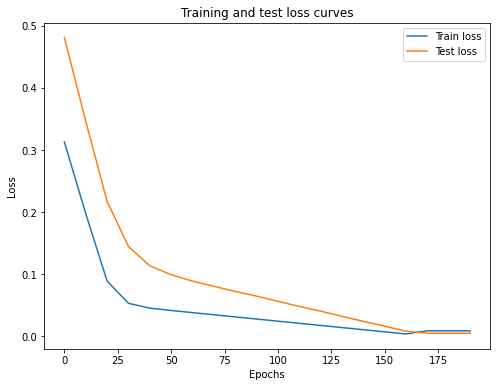

In [ ]:
# Plot the curves
plt.figure(figsize = (8, 6))
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

But, why did the loss go down? Well, thank to our loss function and optimizer, the model's internal parameters (`weight` and `bias`) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's `.state_dict()` to see how close our model gets to the original values we set for weights and bias.

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Our model got very close to calculate the exact original values for `weight` and `bias`.

I'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

# 4. Making predictions with a trained PyTorch model (inference)

There are three things to remember whe making predictions (also called performing **inference**) with a PyTorch model:
1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode():`).
3. All predictions should be made with objects on the same device (e.g., data and model on GPU only or data and model on CPU only).

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

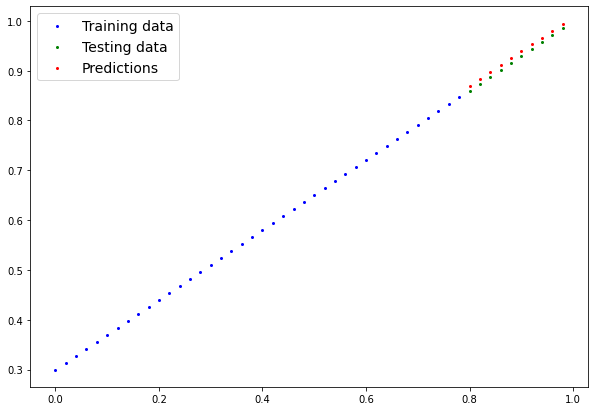

In [ ]:
plot_predictions(predictions = y_preds)

# 5. Saving and loading a PyTorch model

For saving and loading models in PyTorch, there are three main methods you should be aware of:
1. **`torch.save`**: Saves a serialized object to disk using Python's `pickle` utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.
2. **`torch.load`**: Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU, etc.).
3. **`torch.nn.Module.load_state_dict`**: Loads a model´s parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object.

> **Note**: The `pickle` module **is not secure**. That means you should only ever unpicklead (load) data you trust.

## Saving a PyTorch model's `state_dict()`

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:
1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note**: It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.



In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),  # only saving the state_dict() only saves the models learned parameters
           f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1063 Sep  1 18:12 models/01_pytorch_workflow_model_0.pth


## Loading a saved PyTorch model's `state_dict()`

We can now load it using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

**Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?**

Because we only saved the model's `state_dict` which is a dictionary of learned parameters and no the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

**Why not save the entire model?**

Saving the entire model rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation:

> The disadventage of this approach (*saving the whole model*) is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by created another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dit()`.

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

To test our loaded model, let's perform inference with it (make predictions) on the test data.

> **PyTorch inference rules**: 
> 1. Set the model in evaluation mode (`model.eval()`).
> 2. Make predictions using the inference mode context manager (`with torch.inference_mode():`).
> 3. All predictions should be made with objects on the same device (e.g., data and model on GPU only or data and model on CPU only).

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [ ]:
# Compare previous model predictions with loaded model predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

Let's put everything we've done so far together.

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cu113'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1) Data

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

**Split the data**: We'll use an 80/20 split.

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize = (10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop = {"size":14});

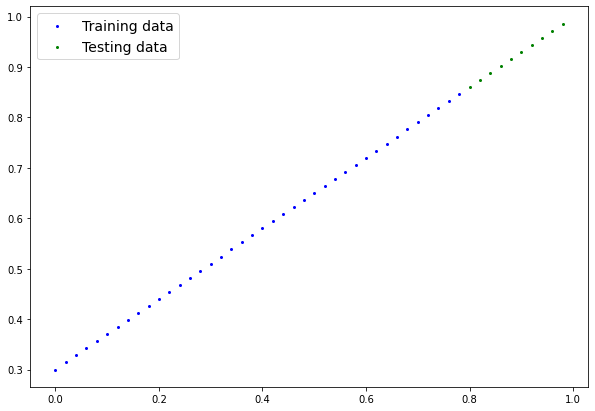

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2) Building a PyTorch linear model

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are `1` since our data has `1` input feature (`X`) per label (`y`).

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)


In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

  # Define the forward computation
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed when creating the model
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Now let's put our model on the GPU (if it's available).

We can change the device our PyTorch objects are on using `.to(device)`.

First let's check the model's current device.

In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

Looks like the model's on the CPU by default.

Let's change it to be on the GPU (if it's available).

In [ ]:
# Set model to GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 3) Training

In [ ]:
# Create loss function (MAE)
loss_fn = nn.L1Loss()

# Creat optimizer (SGD)
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target `device`.

We've already put our model on the target `device` using `model_1.to(device)`.

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set `epochs = 1000`.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  # train mode is on by default after construction
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  # put the model in evaluation mode for testing
  model_1.eval()

  # 1. Forward pass
  with torch.inference_mode():
    test_pred = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 100 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 200 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 300 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 400 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 500 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 600 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 700 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 800 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 900 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523


> **Note**: Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending o whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device.
>
> If the difference is large, you may want to look for erros, however, if it is small (ideally it is), you can ignore it.

Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')), ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4) Making predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

> **Note**: Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. 
>
>So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. 
>
>To fix this, you can call `.cpu()` on your target tensor to return a copy of your target tensor on the CPU.

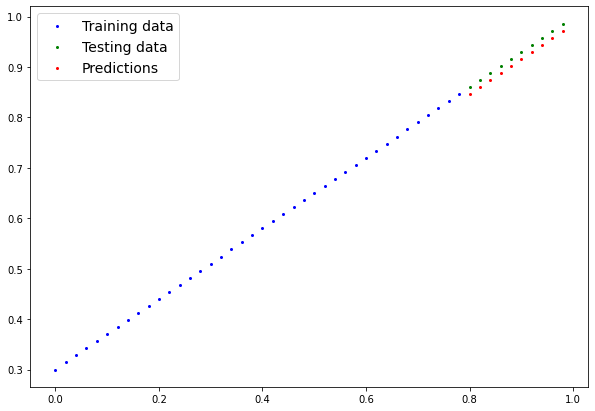

In [ ]:
# Plot data on the CPU and plot it
plot_predictions(predictions = y_preds.cpu())

## 5) Saving and loading a model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


And just to make sure everything worked well, let's load it back in.

We'll

* Create a new instance of the `LinearRegressionModelV2()` class.
* Load in the model state dict using `torch.nn.Model.load_state_dict()`.
* Send the new instance of the model to the target device (to ensure our code is device-agnostic).

In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the mode to target device ((f your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


Now we can evaluate the loaded model to see if its predictions line up with the predictions made prior to saving.

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

Everything adds up! Nice!

Well, we've come a long way. You've now built and trained your first two neural network models in PyTorch!